## Installation

In [2]:
!pip install torch
!pip install torchvision

  Using cached torch-2.4.1-cp310-cp310-manylinux1_x86_64.whl.metadata (26 kB)
  Using cached networkx-3.3-py3-none-any.whl.metadata (5.1 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Usi

In [3]:
!unzip SAR_Image_Colorization_Pairs.zip -d ./SAR_Image_Colorization_Pairs/

Archive:  SAR_Image_Colorization_Pairs.zip
   creating: ./SAR_Image_Colorization_Pairs/SAR_Image_Colorization_Pairs/Pair-1/
  inflating: ./SAR_Image_Colorization_Pairs/SAR_Image_Colorization_Pairs/Pair-1/Optical-Image-1.jpg  
  inflating: ./SAR_Image_Colorization_Pairs/SAR_Image_Colorization_Pairs/Pair-1/SAR-Image-1.jpg  
   creating: ./SAR_Image_Colorization_Pairs/SAR_Image_Colorization_Pairs/Pair-2/
  inflating: ./SAR_Image_Colorization_Pairs/SAR_Image_Colorization_Pairs/Pair-2/Optical-Image-2.jpg  
  inflating: ./SAR_Image_Colorization_Pairs/SAR_Image_Colorization_Pairs/Pair-2/SAR-Image-2.jpg  
   creating: ./SAR_Image_Colorization_Pairs/SAR_Image_Colorization_Pairs/Pair-3/
  inflating: ./SAR_Image_Colorization_Pairs/SAR_Image_Colorization_Pairs/Pair-3/Optical-Image-3.jpg  
  inflating: ./SAR_Image_Colorization_Pairs/SAR_Image_Colorization_Pairs/Pair-3/SAR-Image-3.jpg  


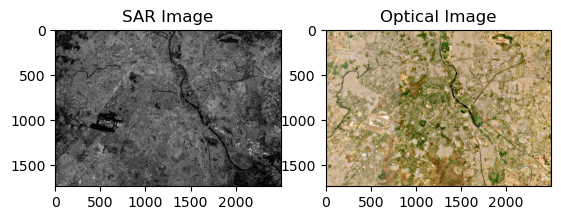

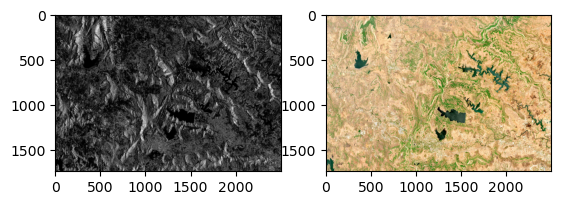

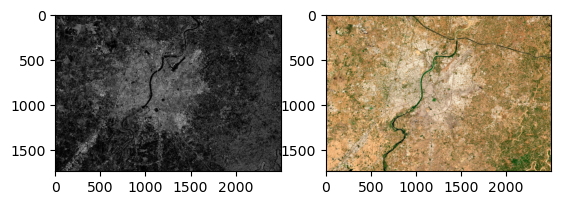

In [4]:
from PIL import Image
import matplotlib.pyplot as plt

sar_image_1 = Image.open('SAR_Image_Colorization_Pairs/SAR_Image_Colorization_Pairs/Pair-1/SAR-Image-1.jpg')
optical_image_1 = Image.open('SAR_Image_Colorization_Pairs/SAR_Image_Colorization_Pairs/Pair-1/Optical-Image-1.jpg')

sar_image_2 = Image.open('SAR_Image_Colorization_Pairs/SAR_Image_Colorization_Pairs/Pair-2/SAR-Image-2.jpg')
optical_image_2 = Image.open('SAR_Image_Colorization_Pairs/SAR_Image_Colorization_Pairs/Pair-2/Optical-Image-2.jpg')

sar_image_3 = Image.open('SAR_Image_Colorization_Pairs/SAR_Image_Colorization_Pairs/Pair-3/SAR-Image-3.jpg')
optical_image_3 = Image.open('SAR_Image_Colorization_Pairs/SAR_Image_Colorization_Pairs/Pair-3/Optical-Image-3.jpg')

plt.subplot(1, 2, 1)
plt.title("SAR Image")
plt.imshow(sar_image_1, cmap='gray')
plt.subplot(1, 2, 2)
plt.title("Optical Image")
plt.imshow(optical_image_1)
plt.show()

plt.subplot(1, 2, 1)
plt.imshow(sar_image_2, cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(optical_image_2)
plt.show()

plt.subplot(1, 2, 1)
plt.imshow(sar_image_3, cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(optical_image_3)
plt.show()

## Pre-process Data

In [24]:
import os
from PIL import Image
from torch.utils.data import Dataset
import torchvision.transforms as transforms

# Define image transformations
optical_transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize images
    transforms.ToTensor(),          # Convert images to PyTorch tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize RGB Optical images
])

sar_transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize images
    transforms.ToTensor(),          # Convert images to PyTorch tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize grayscale SAR images
])

# Define a custom dataset class for loading paired images
class SAROpticalDataset(Dataset):
    def __init__(self, root_dir, sar_transform=None, optical_transform=None):
        self.root_dir = root_dir
        self.sar_transform = sar_transform
        self.optical_transform = optical_transform

        # Get a list of the folder names (set1, set2, set3, etc.)
        self.set_folders = sorted(os.listdir(self.root_dir))

    def __len__(self):
        return len(self.set_folders)

    def __getitem__(self, idx):
        set_folder = os.path.join(self.root_dir, self.set_folders[idx])

        # Load SAR and Optical images from each set folder
        sar_image_path = os.path.join(set_folder, 'SAR-Image-' + str(idx + 1) + '.jpg')
        optical_image_path = os.path.join(set_folder, 'Optical-Image-' + str(idx + 1) + '.jpg')

        # Convert SAR image to grayscale and Optical image to RGB
        sar_image = Image.open(sar_image_path).convert('L')  # 'L' mode is for grayscale
        optical_image = Image.open(optical_image_path).convert('RGB')

        # Apply transformations if available
        if self.sar_transform:
            sar_image = self.sar_transform(sar_image)
        if self.optical_transform:
            optical_image = self.optical_transform(optical_image)

        # Return the SAR and Optical images as a dictionary
        return {'sar': sar_image, 'optical': optical_image}

# Sample usage of the dataset
root_dir = './SAR_Image_Colorization_Pairs/SAR_Image_Colorization_Pairs'  # Replace with the actual path
dataset = SAROpticalDataset(root_dir=root_dir, sar_transform=sar_transform, optical_transform=optical_transform)

# Test loading a single item
sample_data = dataset[0]  # Load the first sample

# Check the shape of the images
print(sample_data['sar'].shape)  # Should print (1, 256, 256) for SAR
print(sample_data['optical'].shape)  # Should print (3, 256, 256) for Optical

torch.Size([1, 256, 256])
torch.Size([3, 256, 256])


## Loading Dataset

In [25]:
import torch

In [28]:
# Instantiate the dataset with separate SAR and Optical transformations
dataset = SAROpticalDataset(
    root_dir='./SAR_Image_Colorization_Pairs/SAR_Image_Colorization_Pairs/', 
    sar_transform=sar_transform, 
    optical_transform=optical_transform
)

# Instantiate the DataLoader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)

# Test loading the first batch
batch = next(iter(dataloader))
print(batch['sar'].shape)  # Should print (1, 1, 256, 256) for SAR
print(batch['optical'].shape)  # Should print (1, 3, 256, 256) for Optical

torch.Size([1, 1, 256, 256])
torch.Size([1, 3, 256, 256])


In [29]:
import torch

# Check if a GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Model Arch

In [71]:
import torch
import torch.nn as nn
import torch.optim as optim
from itertools import chain

# Define the Generator (SAR2Optical and Optical2SAR share same structure)
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        # Use a series of downsampling, residual, and upsampling layers
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=1, padding=3, bias=False),
            nn.ReLU(inplace=True),
            # Downsampling
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            # Residual blocks
            *[ResBlock(256) for _ in range(9)],
            # Upsampling
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 3, kernel_size=7, stride=1, padding=3),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)

# Define the Discriminator (basic PatchGAN discriminator)
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=1, padding=1),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1),
        )

    def forward(self, x):
        return self.main(x)

# Residual Block for the Generator
class ResBlock(nn.Module):
    def __init__(self, channels):
        super(ResBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1),
            nn.InstanceNorm2d(channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1),
            nn.InstanceNorm2d(channels)
        )

    def forward(self, x):
        return x + self.block(x)

# Initialize Generators and Discriminators
netG_SAR2Optical = Generator().to(device)  # SAR -> Optical
netG_Optical2SAR = Generator().to(device)  # Optical -> SAR
netD_Optical = Discriminator().to(device)  # Discriminator for Optical images
netD_SAR = Discriminator().to(device)  # Discriminator for SAR images

## Loss Function

In [91]:
# Adversarial Loss (BCEWithLogits for better stability)
adversarial_loss = nn.MSELoss()

# Cycle Consistency Loss (L1 Loss)
cycle_consistency_loss = nn.L1Loss()

# Identity Loss (L1 Loss)
identity_loss = nn.L1Loss()

# Optimizers
optimizer_G = optim.Adam(chain(netG_SAR2Optical.parameters(), netG_Optical2SAR.parameters()), lr=0.0002, betas=(0.5, 0.999))
optimizer_D_Optical = optim.Adam(netD_Optical.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D_SAR = optim.Adam(netD_SAR.parameters(), lr=0.0002, betas=(0.5, 0.999))

lambda_cycle = 10.0  # Cycle consistency weight
lambda_identity = 5.0  # Identity loss weight

## Training

In [77]:
!pip install opencv-python
!pip install opencv-python-headless

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 33.8 MB/s eta 0:00:00:00:0100:01


In [93]:
import torchvision.utils as vutils
import os
import torch
import cv2

def enhance_color(image):
    # Convert from tensor to numpy and ensure it's in [0, 1] range
    if len(image.shape) == 4:  # Batch size is 1
        image = image[0]  # Take the first image from the batch

    # Convert to numpy
    image = image.detach().cpu().numpy().transpose(1, 2, 0)  # Change to (H, W, C)

    # Ensure the image is in the correct range [0, 1]
    image = (image - image.min()) / (image.max() - image.min())

    # Convert to HSV
    hsv_image = cv2.cvtColor((image * 255).astype(np.uint8), cv2.COLOR_RGB2HSV)
    # Increase the saturation
    hsv_image[:, :, 1] = hsv_image[:, :, 1] * 1.5  # Increase saturation
    hsv_image[:, :, 1] = np.clip(hsv_image[:, :, 1], 0, 255)  # Clip to valid range
    # Convert back to RGB
    enhanced_image = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2RGB) / 255.0  # Return to [0, 1]
    
    # Convert back to tensor (C, H, W)
    enhanced_image = torch.from_numpy(enhanced_image.transpose(2, 0, 1))  # Convert to (C, H, W)
    return enhanced_image

# Function to save the generated images
def save_images(epoch, sar_image, optical_image, fake_sar, fake_optical, recovered_sar, recovered_optical, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    vutils.save_image(sar_image, f'{output_dir}/sar_real_epoch_{epoch}_III.png', normalize=True)
    vutils.save_image(optical_image, f'{output_dir}/optical_real_epoch_{epoch}_III.png', normalize=True)
    vutils.save_image(fake_sar, f'{output_dir}/sar_fake_epoch_{epoch}_III.png', normalize=True)
    vutils.save_image(fake_optical, f'{output_dir}/optical_fake_epoch_{epoch}_III.png', normalize=True)
    vutils.save_image(recovered_sar, f'{output_dir}/sar_recovered_epoch_{epoch}_III.png', normalize=True)
    vutils.save_image(recovered_optical, f'{output_dir}/optical_recovered_epoch_{epoch}_III.png', normalize=True)

# Function to save model checkpoints
def save_checkpoint(epoch, model, optimizer, output_dir):
    checkpoint_path = os.path.join(output_dir, f'checkpoint_epoch_{epoch}.pt')
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, checkpoint_path)
    print(f"Checkpoint saved at {checkpoint_path}")

output_dir = './generated_images_III/'

print("fake_optical shape:", fake_optical.shape)
print("fake_sar shape:", fake_sar.shape)

def ensure_three_channels(image):
    # If the image has only one channel, stack it to create 3 channels
    if image.shape[0] == 1:  # Check if single channel
        return np.repeat(image, 3, axis=0)  # Repeat the channel to create a 3-channel image
    return image

# Initialize lists to store loss values
loss_G_SAR2Optical_list = []
loss_G_Optical2SAR_list = []
loss_cycle_SAR_list = []
loss_cycle_Optical_list = []
loss_identity_SAR_list = []
loss_identity_Optical_list = []
total_loss_list = []

# Define the number of epochs
num_epochs = 100 

for epoch in range(num_epochs):
    for i, data in enumerate(dataloader):
        # SAR and Optical images
        sar_image = data['sar'].to(device)
        optical_image = data['optical'].to(device)

        # Repeat the SAR image to match the 3 channels required by the generator
        sar_image = sar_image.repeat(1, 3, 1, 1)  # Repeat the single channel three times

        # ----------------------------------------
        # 1. Train Generators (SAR -> Optical, Optical -> SAR)
        # ----------------------------------------

        optimizer_G.zero_grad()

        # Generator SAR -> Optical
        fake_optical = netG_SAR2Optical(sar_image)
        recovered_sar = netG_Optical2SAR(fake_optical)

        # Generator Optical -> SAR
        fake_sar = netG_Optical2SAR(optical_image)
        recovered_optical = netG_SAR2Optical(fake_sar)
        
        with torch.no_grad():
            fake_optical_for_saving = netG_SAR2Optical(sar_image)
            fake_sar_for_saving = netG_Optical2SAR(optical_image)

            # Enhance colors
            fake_optical_enhanced = enhance_color(fake_optical_for_saving)
            fake_sar_enhanced = enhance_color(fake_sar_for_saving)

            # Save enhanced images
            vutils.save_image(fake_optical_enhanced, f'{output_dir}/optical_fake_enhanced_epoch_{epoch}.png', normalize=False)
            vutils.save_image(fake_sar_enhanced, f'{output_dir}/sar_fake_enhanced_epoch_{epoch}.png', normalize=False)
        
        if isinstance(fake_optical, np.ndarray):
            fake_optical = torch.from_numpy(fake_optical).float().to(device)

        if isinstance(fake_sar, np.ndarray):
            fake_sar = torch.from_numpy(fake_sar).float().to(device)
        
        fake_optical = ensure_three_channels(fake_optical.cpu().detach().numpy())
        fake_sar = ensure_three_channels(fake_sar.cpu().detach().numpy())
        
        # Adversarial Loss
        loss_G_SAR2Optical = adversarial_loss(netD_Optical(fake_optical), torch.ones_like(netD_Optical(fake_optical)))
        loss_G_Optical2SAR = adversarial_loss(netD_SAR(fake_sar), torch.ones_like(netD_SAR(fake_sar)))

        # Cycle Consistency Loss
        loss_cycle_SAR = cycle_consistency_loss(recovered_sar, sar_image) * lambda_cycle
        loss_cycle_Optical = cycle_consistency_loss(recovered_optical, optical_image) * lambda_cycle

        # Identity Loss (optional)
        loss_identity_SAR = identity_loss(netG_Optical2SAR(sar_image), sar_image) * lambda_identity
        loss_identity_Optical = identity_loss(netG_SAR2Optical(optical_image), optical_image) * lambda_identity

        # Total Generator Loss
        loss_G = (loss_G_SAR2Optical + loss_G_Optical2SAR + 
                  loss_cycle_SAR + loss_cycle_Optical + 
                  loss_identity_SAR + loss_identity_Optical)

        loss_G.backward()
        optimizer_G.step()

        # ----------------------------------------
        # 2. Train Discriminators (SAR and Optical)
        # ----------------------------------------

        # Train Discriminator Optical
        optimizer_D_Optical.zero_grad()
        loss_G_SAR2Optical = adversarial_loss(netD_Optical(fake_optical), torch.ones_like(netD_Optical(fake_optical)))
        loss_D_real_Optical = adversarial_loss(netD_Optical(optical_image), torch.ones_like(netD_Optical(optical_image)))
        loss_D_fake_Optical = adversarial_loss(netD_Optical(fake_optical.detach()), torch.zeros_like(netD_Optical(fake_optical)))
        loss_D_Optical = (loss_D_real_Optical + loss_D_fake_Optical) * 0.5
        loss_D_Optical.backward()
        optimizer_D_Optical.step()

        # Train Discriminator SAR
        optimizer_D_SAR.zero_grad()
        loss_G_Optical2SAR = adversarial_loss(netD_SAR(fake_sar), torch.ones_like(netD_SAR(fake_sar)))
        loss_D_real_SAR = adversarial_loss(netD_SAR(sar_image), torch.ones_like(netD_SAR(sar_image)))
        loss_D_fake_SAR = adversarial_loss(netD_SAR(fake_sar.detach()), torch.zeros_like(netD_SAR(fake_sar)))
        loss_D_SAR = (loss_D_real_SAR + loss_D_fake_SAR) * 0.5
        loss_D_SAR.backward()
        optimizer_D_SAR.step()
        
        # Log the losses
        loss_G_SAR2Optical_list.append(loss_G_SAR2Optical.item())
        loss_G_Optical2SAR_list.append(loss_G_Optical2SAR.item())
        loss_cycle_SAR_list.append(loss_cycle_SAR.item())
        loss_cycle_Optical_list.append(loss_cycle_Optical.item())
        loss_identity_SAR_list.append(loss_identity_SAR.item())
        loss_identity_Optical_list.append(loss_identity_Optical.item())
        total_loss_list.append(loss_G.item())
        
        # Print losses occasionally to monitor progress
        if i % 100 == 0:
            print(f"[Epoch {epoch}/{num_epochs}] [Batch {i}/{len(dataloader)}] "
                  f"[D SAR: {loss_D_SAR.item()}] [D Optical: {loss_D_Optical.item()}] "
                  f"[G: {loss_G.item()}]")

        # Save the images every 5 epochs
        if epoch % 5 == 0:
            with torch.no_grad():
                fake_optical = netG_SAR2Optical(sar_image)
                fake_sar = netG_Optical2SAR(optical_image)
                recovered_sar = netG_Optical2SAR(fake_optical)
                recovered_optical = netG_SAR2Optical(fake_sar)

            save_images(epoch, sar_image, optical_image, fake_sar, fake_optical, recovered_sar, recovered_optical, output_dir)

    # Save checkpoint every 10 epochs
    if epoch % 10 == 0:
        save_checkpoint(epoch, netG_SAR2Optical, optimizer_G, output_dir)
        save_checkpoint(epoch, netG_Optical2SAR, optimizer_G, output_dir)
        save_checkpoint(epoch, netD_Optical, optimizer_D_Optical, output_dir)
        save_checkpoint(epoch, netD_SAR, optimizer_D_SAR, output_dir)

fake_optical shape: (3, 3, 256, 256)
fake_sar shape: (3, 3, 256, 256)


TypeError: conv2d() received an invalid combination of arguments - got (numpy.ndarray, Parameter, Parameter, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias = None, tuple of ints stride = 1, tuple of ints padding = 0, tuple of ints dilation = 1, int groups = 1)
      didn't match because some of the arguments have invalid types: (!numpy.ndarray!, !Parameter!, !Parameter!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, !int!)
 * (Tensor input, Tensor weight, Tensor bias = None, tuple of ints stride = 1, str padding = "valid", tuple of ints dilation = 1, int groups = 1)
      didn't match because some of the arguments have invalid types: (!numpy.ndarray!, !Parameter!, !Parameter!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, !int!)


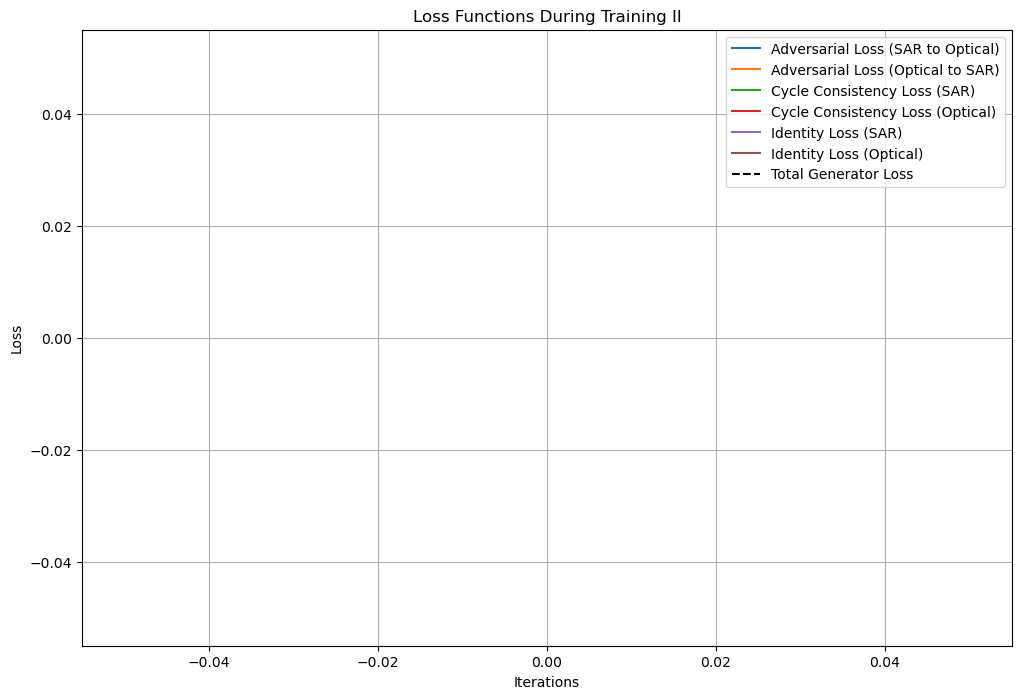

<Figure size 640x480 with 0 Axes>

In [89]:
import matplotlib.pyplot as plt

# Plotting the loss values
plt.figure(figsize=(12, 8))
plt.plot(loss_G_SAR2Optical_list, label='Adversarial Loss (SAR to Optical)')
plt.plot(loss_G_Optical2SAR_list, label='Adversarial Loss (Optical to SAR)')
plt.plot(loss_cycle_SAR_list, label='Cycle Consistency Loss (SAR)')
plt.plot(loss_cycle_Optical_list, label='Cycle Consistency Loss (Optical)')
plt.plot(loss_identity_SAR_list, label='Identity Loss (SAR)')
plt.plot(loss_identity_Optical_list, label='Identity Loss (Optical)')
plt.plot(total_loss_list, label='Total Generator Loss', color='black', linestyle='--')

plt.title('Loss Functions During Training II')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()
plt.savefig('Loss Functions During Training II.png', dpi=300, bbox_inches='tight')

## Eval

In [60]:
# After training, you can use the model to generate images:
netG_SAR2Optical.eval()
fake_optical = netG_SAR2Optical(sar_image)

In [61]:
print("SAR Image shape:", sar_image.shape)
print("Generated Optical Image shape:", fake_optical.shape)
print("Recovered SAR Image shape:", recovered_sar.shape)

SAR Image shape: torch.Size([1, 3, 256, 256])
Generated Optical Image shape: torch.Size([1, 3, 256, 256])
Recovered SAR Image shape: torch.Size([1, 3, 256, 256])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


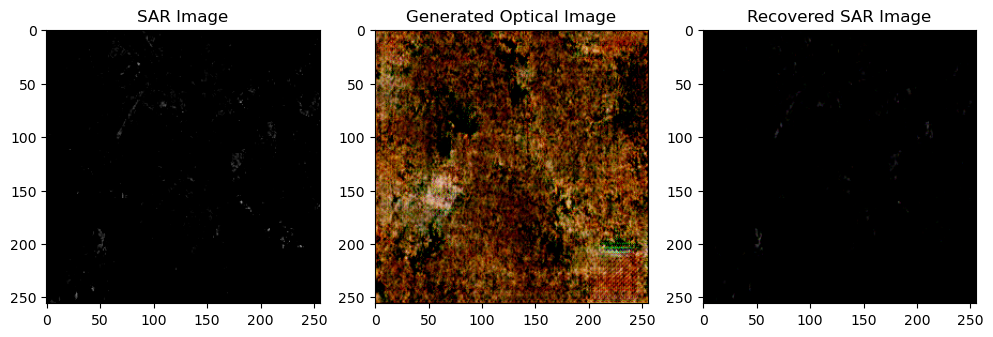

In [62]:
def show_images(sar, fake_optical, recovered_sar):
    plt.figure(figsize=(12, 4))
    
    # Display SAR Image
    plt.subplot(1, 3, 1)
    plt.title("SAR Image")
    sar_image = sar.cpu().detach().numpy()[0]  # Remove batch dimension
    plt.imshow(sar_image.transpose(1, 2, 0))  # Rearrange to (height, width, channels)
    
    # Display Generated Optical Image
    plt.subplot(1, 3, 2)
    plt.title("Generated Optical Image")
    fake_optical_image = fake_optical.cpu().detach().numpy()[0]  # Remove batch dimension
    plt.imshow(fake_optical_image.transpose(1, 2, 0))  # Rearrange to (height, width, channels)

    # Display Recovered SAR Image
    plt.subplot(1, 3, 3)
    plt.title("Recovered SAR Image")
    recovered_image = recovered_sar.cpu().detach().numpy()[0]  # Remove batch dimension
    plt.imshow(recovered_image.transpose(1, 2, 0))  # Rearrange to (height, width, channels)
    
    plt.show()

# Now call the function
show_images(sar_image, fake_optical, recovered_sar)

### adjuting visibility

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


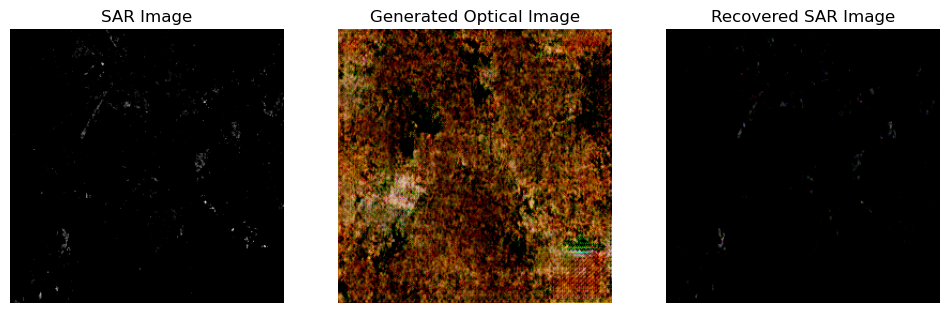

In [63]:
import numpy as np
import matplotlib.pyplot as plt

def enhance_image(image, alpha=1.5, beta=0):  # alpha > 1 increases contrast, beta shifts brightness
    # Ensure image is in [0, 1] range
    image = np.clip(image, 0, 1)
    enhanced = alpha * image + beta
    return np.clip(enhanced, 0, 1)  # Clip values to be in range [0, 1]

# Update the show_images function to enhance the images
def show_images(sar, fake_optical, recovered_sar):
    plt.figure(figsize=(12, 4))
    
    # Display SAR Image
    plt.subplot(1, 3, 1)
    plt.title("SAR Image")
    sar_image = sar.cpu().detach().numpy()[0].transpose(1, 2, 0)  # Rearrange to (height, width, channels)
    sar_image_enhanced = enhance_image(sar_image)  # Enhance the SAR image
    plt.imshow(sar_image_enhanced)
    plt.axis('off')
    
    # Display Generated Optical Image
    plt.subplot(1, 3, 2)
    plt.title("Generated Optical Image")
    fake_optical_image = fake_optical.cpu().detach().numpy()[0].transpose(1, 2, 0)  # Rearrange to (height, width, channels)
    plt.imshow(fake_optical_image)
    plt.axis('off')

    # Display Recovered SAR Image
    plt.subplot(1, 3, 3)
    plt.title("Recovered SAR Image")
    recovered_image = recovered_sar.cpu().detach().numpy()[0].transpose(1, 2, 0)  # Rearrange to (height, width, channels)
    recovered_image_enhanced = enhance_image(recovered_image)  # Enhance the recovered image
    plt.imshow(recovered_image_enhanced)
    plt.axis('off')
    
    plt.show()

# Now call the function
show_images(sar_image, fake_optical, recovered_sar)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


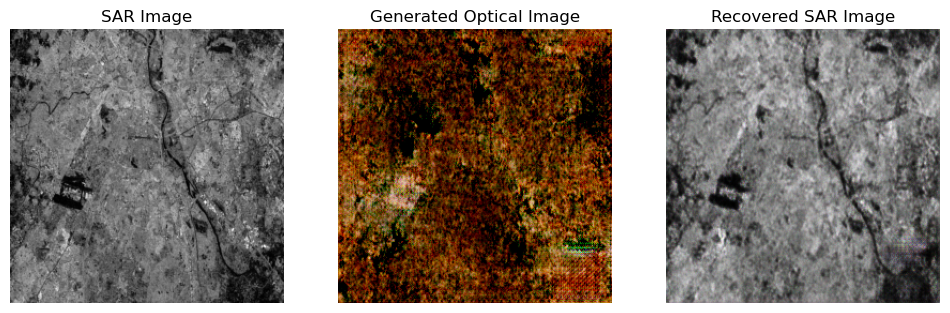

In [64]:
def normalize_image(image):
    # Normalize to [0, 1] range
    return (image - np.min(image)) / (np.max(image) - np.min(image))

# Update the show_images function to normalize the images
def show_images(sar, fake_optical, recovered_sar):
    plt.figure(figsize=(12, 4))
    
    # Display SAR Image
    plt.subplot(1, 3, 1)
    plt.title("SAR Image")
    sar_image = sar.cpu().detach().numpy()[0].transpose(1, 2, 0)  # Rearrange to (height, width, channels)
    sar_image_normalized = normalize_image(sar_image)  # Normalize the SAR image
    plt.imshow(sar_image_normalized)
    plt.axis('off')
    
    # Display Generated Optical Image
    plt.subplot(1, 3, 2)
    plt.title("Generated Optical Image")
    fake_optical_image = fake_optical.cpu().detach().numpy()[0].transpose(1, 2, 0)  # Rearrange to (height, width, channels)
    plt.imshow(fake_optical_image)
    plt.axis('off')

    # Display Recovered SAR Image
    plt.subplot(1, 3, 3)
    plt.title("Recovered SAR Image")
    recovered_image = recovered_sar.cpu().detach().numpy()[0].transpose(1, 2, 0)  # Rearrange to (height, width, channels)
    recovered_image_normalized = normalize_image(recovered_image)  # Normalize the recovered image
    plt.imshow(recovered_image_normalized)
    plt.axis('off')
    
    plt.show()

# Now call the function
show_images(sar_image, fake_optical, recovered_sar)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


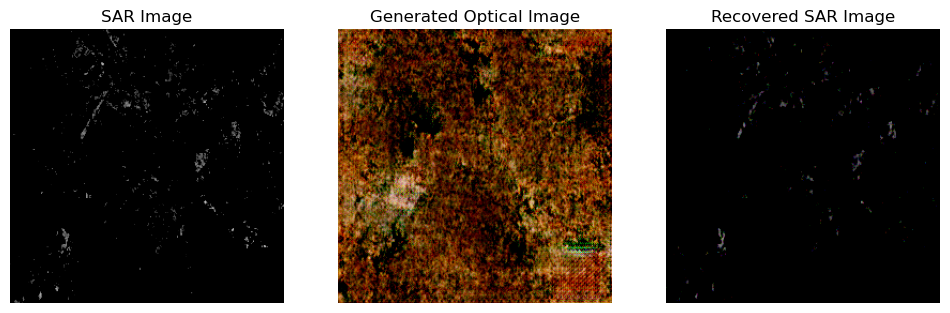

In [65]:
def gamma_correction(image, gamma=2.0):
    # Ensure values are in range [0, 1]
    image = np.clip(image, 0, 1)  
    image_corrected = image ** (1.0 / gamma)  # Apply gamma correction
    return image_corrected

# Update the show_images function to include gamma correction
def show_images(sar, fake_optical, recovered_sar):
    plt.figure(figsize=(12, 4))
    
    # Display SAR Image
    plt.subplot(1, 3, 1)
    plt.title("SAR Image")
    sar_image = sar.cpu().detach().numpy()[0].transpose(1, 2, 0)  # Rearrange to (height, width, channels)
    sar_image_gamma_corrected = gamma_correction(sar_image)  # Apply gamma correction
    plt.imshow(sar_image_gamma_corrected)
    plt.axis('off')
    
    # Display Generated Optical Image
    plt.subplot(1, 3, 2)
    plt.title("Generated Optical Image")
    fake_optical_image = fake_optical.cpu().detach().numpy()[0].transpose(1, 2, 0)  # Rearrange to (height, width, channels)
    plt.imshow(fake_optical_image)
    plt.axis('off')

    # Display Recovered SAR Image
    plt.subplot(1, 3, 3)
    plt.title("Recovered SAR Image")
    recovered_image = recovered_sar.cpu().detach().numpy()[0].transpose(1, 2, 0)  # Rearrange to (height, width, channels)
    recovered_image_gamma_corrected = gamma_correction(recovered_image)  # Apply gamma correction
    plt.imshow(recovered_image_gamma_corrected)
    plt.axis('off')
    
    plt.show()

# Now call the function
show_images(sar_image, fake_optical, recovered_sar)